## Ulu 2023 Test Set

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sns
import shutil
import os 
import glob
import csv
import json
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as confusion_matrix_sklearn

from ketos.data_handling import selection_table as sl
import ketos.data_handling.database_interface as dbi
from ketos.data_handling.parsing import load_audio_representation
from ketos.data_handling.data_feeding import BatchGenerator
from ketos.neural_networks.resnet import ResNetInterface
from ketos.audio.audio_loader import AudioFrameLoader, AudioLoader, SelectionTableIterator
from ketos.audio.spectrogram import MagSpectrogram
from ketos.neural_networks.dev_utils.detection import batch_load_audio_file_data, filter_by_threshold, filter_by_label, merge_overlapping_detections
from ketos.data_handling.data_feeding import JointBatchGen

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

print('done importing packages')

done importing packages


C:\Users\kzammit\Miniconda3\envs\ketos_env\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


## Format Annotation Table

In [29]:
def concat_annot(sel_tables_folder):
    """

    :param sel_tables_folder:
    :return:
    """

    files = glob.glob(sel_tables_folder + '\*.txt')

    for fdex, file in enumerate(files):

        df = pd.read_csv(file, sep='\t', encoding='latin1')
        df = df.rename(columns={'KZ Keep? (Y/X/M)': "keep_drop"})
        #df = df[df.keep_drop == 'Y']

        if 'CB' in file:
            site_name = file.split('\\')[-1].split('_')[0]
        elif 'Ulukhaktok' in file:
            site_name = file.split('\\')[-1].split('_')[0] + '.' + file.split('\\')[-1].split('_')[1]
        elif 'ulu.2022' in file:
            site_name = 'ulu.2022'
        elif 'ulu.2023' in file:
            site_name = file.split('\\')[-1].split('_')[0]
        else:
            site_name = file.split('\\')[-1].split('_')[0] + '.' + file.split('\\')[-1].split('_')[1] + '.' + \
                        file.split('\\')[-1].split('_')[2]

        df.insert(0, 'site_name', site_name)

        if fdex == 0:
            df_all = df
        else:
            df_all = pd.concat([df_all, df], ignore_index=True)

    return df_all

In [78]:
def format_annot(df, output_name):
    """

    :param df:
    :param output_name:
    :return:
    """

    writer = pd.ExcelWriter(output_name, engine='xlsxwriter')

    # set start and end time of annotation
    df['start'] = df['File Offset (s)']
    df['Delta Time (s)'] = df['End Time (s)'] - df['Begin Time (s)']
    df['end'] = df['File Offset (s)'] + df['Delta Time (s)']

    # rename the begin-path column for easier reference
    df = df.rename(columns={'Begin Path': "filename"})

    # initiate an empty df for the complete annotations
    df_annot = pd.DataFrame(columns=df.columns)

    # get the names of each unique wav file
    unique_files = df['filename'].unique()

    # loop through each unique wav, and set the annot_id for each one
    for fdex, wavF in enumerate(unique_files):

        # create a temp df that only has the entries for this wav file
        df_temp = df[df.filename == wavF]

        # reset the index
        df_temp = df_temp.reset_index(drop=True)

        # set the annot_id column to 'not set' initially
        df_temp['annot_id'] = 'not set'

        # start the counter at 0
        annot_id = 0

        # for the number of annotations with this wav file,
        for ii in range(0, len(df_temp)):
            # set the annot_id incrementally
            df_temp['annot_id'][ii] = annot_id
            annot_id += 1

        # append this wav files info to the df_annot df
        df_annot = pd.concat([df_annot, df_temp], ignore_index=True)

    df_annot = df_annot.rename(columns={'Call Type': "call_type"})

    df_annot_sub = df_annot[['site_name', 'Selection', 'filename', 'start', 'end', 'annot_id']]

    df_annot_sub['label'] = df_annot['call_type']

    df_annot_sub.to_excel(writer, index=False)
    writer.close()

    return df_annot_sub


In [31]:
if __name__ == "__main__":

    output_dir = r'D:\ringed_seal_selection_tables\ulu2023'

    # path to folder with selection tables
    sel_table_path = r'D:\ringed_seal_selection_tables\ulu2023'

    # name of output selection tables excel workbook (just for reference)
    output_file_trim = output_dir + r'\all_annotations.xlsx'

    # call the trim_tables function, and set the output excel workbook file name
    # note I commented out the intermediate output file
    all_annot_orig = concat_annot(sel_table_path)

    # output an Excel sheet with all the annotations before splitting
    formatted_table = format_annot(all_annot_orig, output_name=output_dir + r'\all_annotations_20240304.xlsx')


In [32]:
all_annots_2023 = formatted_table
print(formatted_table.head)

<bound method NDFrame.head of     site_name Selection                                           filename  \
0    ulu.2023         1  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
1    ulu.2023         2  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
2    ulu.2023         3  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
3    ulu.2023         4  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
4    ulu.2023         5  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
..        ...       ...                                                ...   
470  ulu.2023       468  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
471  ulu.2023       469  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
472  ulu.2023       470  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
473  ulu.2023       472  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   
474  ulu.2023       473  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...   

        start         end annot_i

In [33]:
std_annot_all_pos = sl.standardize(table=all_annots_2023, labels=["B", "BY"], start_labels_at_1=True, trim_table=True)

In [34]:
print(std_annot_all_pos)

                                                                start  \
filename                                           annot_id             
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0          47.5464   
                                                   1         298.6775   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0           0.2307   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0         108.7316   
                                                   1         112.2196   
...                                                               ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 3         290.0421   
                                                   4         290.6947   
                                                   5         291.2314   
                                                   6         291.6592   
                                                   7         292.4496   

                                                  

In [35]:
std_annot_all_pos['label'] = std_annot_all_pos['label'].replace(2, 1)

In [36]:
print(std_annot_all_pos)

                                                                start  \
filename                                           annot_id             
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0          47.5464   
                                                   1         298.6775   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0           0.2307   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0         108.7316   
                                                   1         112.2196   
...                                                               ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 3         290.0421   
                                                   4         290.6947   
                                                   5         291.2314   
                                                   6         291.6592   
                                                   7         292.4496   

                                                  

## Calculate File Durations

In [24]:
def calc_file_durations(data_folder):
    """

    :param data_folder:
    :return:
    """
    folders = [r'D:\ringed-seal-data\Ulu_2023_St5_Site65']

    file_durations = pd.DataFrame()
    for folder in folders:

        folder_name = folder.split('\\')[-1]

        # get the durations for all the files within this folder
        file_durations_for_folder = sl.file_duration_table(data_folder)

        # it only keeps the wav filename, need to append the path back onto it I think? Let's try that
        file_durations_for_folder['fixed_filename'] = folder + "\\" + file_durations_for_folder['filename']

        # drop the og filename column
        file_durations_for_folder = file_durations_for_folder.drop(['filename'], axis=1)

        # rename the appended filename
        file_durations_for_folder = file_durations_for_folder.rename(columns={'fixed_filename': 'filename'})

        #file_durations = file_durations.append(sl.file_duration_table(data_folder + "\\" + str(folder_name)))
        file_durations = pd.concat([file_durations, file_durations_for_folder])
        #file_durations = file_durations.append(file_durations_for_folder)

    #print(len(file_durations))
    #file_durations.to_excel('Ulu_durations.xlsx', index=False)

    #file_durations.to_excel('file_durations_minusUlu.xlsx', index=False)

    file_durations.to_excel(r'D:\ringed_seal_selection_tables\ulu2023\file_durations_ulu2023.xlsx', index=False)

In [25]:
calc_file_durations(r'D:\ringed-seal-data\Ulu_2023_St5_Site65')

## Get Selections from Annotation Table

In [39]:
positives = sl.select(annotations=std_annot_all_pos, length=1.0, step=1, min_overlap=1, center=False)

In [40]:
print(positives)

                                                           label       start  \
filename                                           sel_id                      
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0           1   46.965953   
                                                   1           1  298.585025   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0           1    0.208014   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0           1  109.677299   
                                                   1           1  110.677299   
...                                                          ...         ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 3           1  289.387815   
                                                   4           1  290.300497   
                                                   5           1  290.827127   
                                                   6           1  291.315548   
                                        

In [42]:
positives.to_excel(r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx')

## Plot Spectrograms

In [53]:
def load_audio_seg(annot_file, spec_file, data_dir):
    """
    Plot spectrograms for review
    :param annot_file: annotation file (xlsx)
    :param spec_file: spectrogram file
    :param data_dir: directory where data is stored (main level)
    :return:
    """

    annot = pd.read_excel(annot_file)

    # something up with loading in the spectro file
    f = open(spec_file)
    spec_info = json.load(f)
    rep = spec_info['spectrogram']

    # deal with merging of cells in the annotations table
    for ii in range(0, len(annot)):
        if type(annot.loc[ii][0]) == str:
            filename = annot.loc[ii][0]
        else:
            filename = annot['filename'][ii]

    # standardize tables
    annot = annot.ffill()
    annot_std = sl.standardize(table=annot)
    print('table standardized? ' + str(sl.is_standardized(annot_std)))

    # create a generator for iterating over all the selections
    generator = SelectionTableIterator(data_dir=data_dir, selection_table=annot_std)

    # Create a loader by passing the generator and the representation to the AudioLoader
    loader = AudioLoader(selection_gen=generator, representation=MagSpectrogram, representation_params=rep, pad=False)

    # print number of segments
    print('Total number of segments is ' + str(loader.num()))
    annots = float(loader.num())

    return annots, loader


In [60]:
def plot_spectrogram(annot, loader, output_dir):

    for ii in range(0, int(annot)):
        spec = next(loader)
        #print('plotting annot #' + str(ii))
        fig = spec.plot(label_in_title=False)
        path = output_dir
        figname = path + "\\" + str(ii) + '.png'
        fig.savefig(figname, bbox_inches='tight')
        plt.close()

In [61]:
data_dir = r"D:\ringed-seal-data"
spec_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

annot_files = [r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx']

output_dirs = [r'D:\ringed_seal_selection_tables\ulu2023\spectro']

for idx, folder in enumerate(annot_files):

    # create an audioloader with the spectrograms
    annot, loader = load_audio_seg(annot_files[idx], spec_file, data_dir)

    # take audio segments and create spectrogram representation
    plot_spectrogram(annot, loader, output_dirs[idx])

table standardized? True
Total number of segments is 511


In [64]:
def plot_multi_spectrogram(annot, loader, output_dir):
    """
    Plots spectrograms from an audioLoader item, call load_audio_seg first, less options than the old function
    but more useful (?)
    :param annot: annotation table returned from load_audio_seg
    :param loader: audioloader returned from load_audio_seg
    :param output_dir: output path to where you want the image saved
    :return:
    """

    # Ulu good positive numbers: 2, 4, 27, 55


    fig, axs = plt.subplots(2, 2, sharey=True, figsize=(12,9), gridspec_kw={'height_ratios': [1, 1]})

    spec = loader.load(data_dir, loader.selection_gen.get_selection(2)['filename'],
                       loader.selection_gen.get_selection(2)['offset'],
                       loader.selection_gen.get_selection(2)['duration'])
    x = spec.get_data()
    extent = (0., spec.duration(), spec.freq_min(), spec.freq_max())  # axes ranges
    img = axs[0, 0].imshow(x.T, aspect='auto', origin='lower', extent=extent, vmin=None, vmax=None)  # draw image
    axs[0, 0].set_ylabel(spec.freq_ax.label)

    if spec.decibel:
        fig.colorbar(img, ax=axs[0, 0], format='%+2.0f dB')
    else:
        fig.colorbar(img, ax=axs[0, 0], label='Amplitude')

    spec = loader.load(data_dir, loader.selection_gen.get_selection(4)['filename'],
                       loader.selection_gen.get_selection(4)['offset'],
                       loader.selection_gen.get_selection(4)['duration'])
    x = spec.get_data()
    extent = (0., spec.duration(), spec.freq_min(), spec.freq_max())  # axes ranges
    img = axs[0, 1].imshow(x.T, aspect='auto', origin='lower', extent=extent, vmin=None, vmax=None)  # draw image
    #axs[0, 1].set_ylabel(spec.freq_ax.label)

    if spec.decibel:
        fig.colorbar(img, ax=axs[0, 1], format='%+2.0f dB')
    else:
        fig.colorbar(img, ax=axs[0, 1], label='Amplitude')

    spec = loader.load(data_dir, loader.selection_gen.get_selection(27)['filename'],
                       loader.selection_gen.get_selection(27)['offset'],
                       loader.selection_gen.get_selection(27)['duration'])
    x = spec.get_data()
    extent = (0., spec.duration(), spec.freq_min(), spec.freq_max())  # axes ranges
    img = axs[1, 0].imshow(x.T, aspect='auto', origin='lower', extent=extent, vmin=None, vmax=None)  # draw image
    axs[1, 0].set_ylabel(spec.freq_ax.label)
    axs[1, 0].set_xlabel('Time (s)')

    if spec.decibel:
        fig.colorbar(img, ax=axs[1, 0], format='%+2.0f dB')
    else:
        fig.colorbar(img, ax=axs[1, 0], label='Amplitude')

    # ulu 56
    # cb 147
    spec = loader.load(data_dir, loader.selection_gen.get_selection(182)['filename'],
                       loader.selection_gen.get_selection(182)['offset'],
                       loader.selection_gen.get_selection(182)['duration'])
    x = spec.get_data()
    extent = (0., spec.duration(), spec.freq_min(), spec.freq_max())  # axes ranges
    img = axs[1, 1].imshow(x.T, aspect='auto', origin='lower', extent=extent, vmin=None, vmax=None)  # draw image
    #axs[1, 1].set_ylabel(spec.freq_ax.label)
    axs[1, 1].set_xlabel('Time (s)')

    if spec.decibel:
        fig.colorbar(img, ax=axs[1, 1], format='%+2.0f dB')
    else:
        fig.colorbar(img, ax=axs[1, 1], label='Amplitude')

    fig.suptitle('Positive Spectrograms with Normalization')
    #plt.show()
    fig.savefig(r'D:\ringed_seal_selection_tables\ulu2023\positive-spectrograms.png')

table standardized? True
Total number of segments is 511


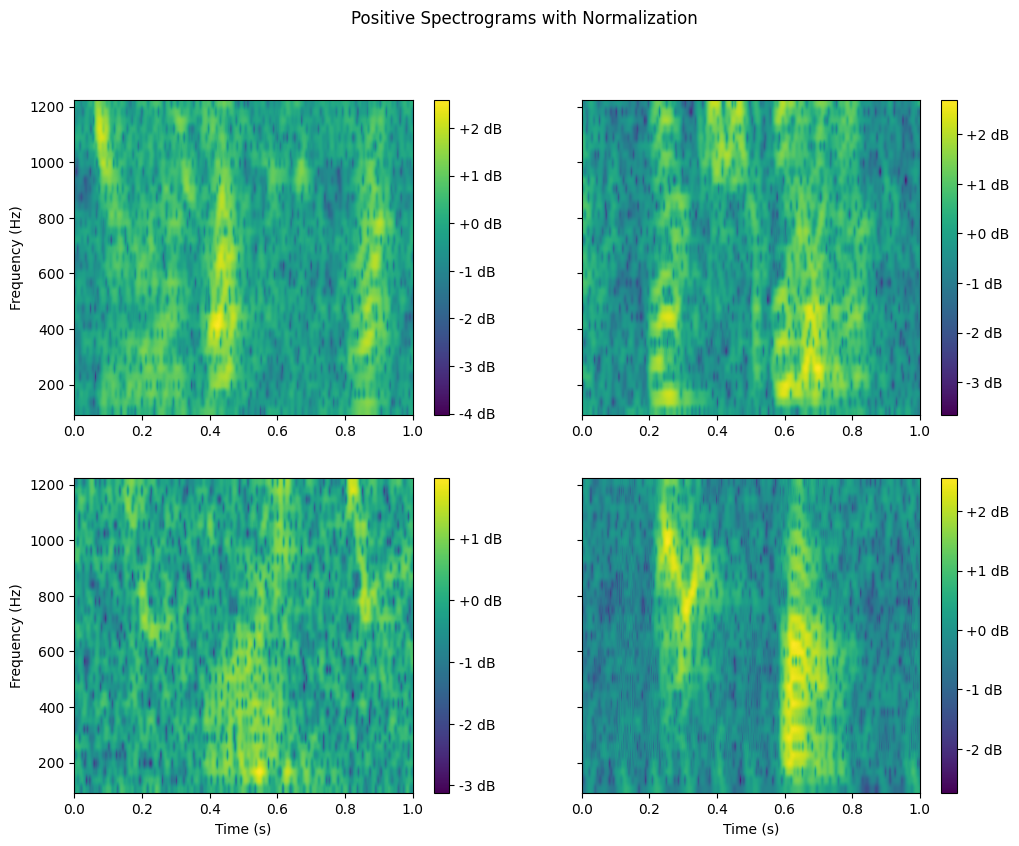

In [66]:
annot_file = r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx'
data_dir = r"D:\ringed-seal-data"
output_dir = r'D:\ringed_seal_selection_tables\ulu2023'
spec_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

# create an audioloader with the spectrograms
annot, loader = load_audio_seg(annot_file, spec_file, data_dir)

# take audio segments and create spectrogram representation
plot_multi_spectrogram(annot, loader, output_dir)

## Generate Negative Segments

In [72]:
all_annot_table = pd.read_csv(r'D:\ringed_seal_selection_tables\original-annotations\S065_final_sound_table.txt', delimiter='\t')
file_durations = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\file_durations_ulu2023.xlsx')

In [73]:
print(all_annot_table.head)
print(file_durations.head)

<bound method NDFrame.head of       Selection           View  Channel  Begin Time (s)  End Time (s)  \
0             1     Waveform 1        1     1992.383060   1992.383060   
1             1  Spectrogram 1        1     1992.383060   1992.383060   
2             2     Waveform 1        1     2108.837350   2108.837350   
3             2  Spectrogram 1        1     2108.837350   2108.837350   
4             5     Waveform 1        1     2300.245754   2300.245754   
...         ...            ...      ...             ...           ...   
7311       3803  Spectrogram 1        1    28027.936940  28027.936940   
7312       3804     Waveform 1        1    32399.643100  32399.643100   
7313       3804  Spectrogram 1        1    32399.643100  32399.643100   
7314       3805     Waveform 1        1    30543.819820  30543.819820   
7315       3805  Spectrogram 1        1    30543.819820  30543.819820   

      Low Freq (Hz)  High Freq (Hz)             Begin File  File Offset (s)  \
0          137

In [76]:
file_durations_edited = file_durations[file_durations['filename'].isin(all_annot_table['Begin Path'])]

In [77]:
print(file_durations_edited)

       duration                                           filename
6    300.010167  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
7    300.094667  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
8    300.010333  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
9    300.050833  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
10   300.000500  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
..          ...                                                ...
792  300.021500  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
798  300.042000  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
804  300.074333  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
816  299.991500  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...
822  300.036333  D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.2...

[258 rows x 2 columns]


In [83]:
all_annot_table['site_name'] = 'ulu.2023'
all_annot_table = all_annot_table.rename(columns={'Sound Type': 'call_type'})

In [85]:
output_name = r'D:\ringed_seal_selection_tables\ulu2023\all-annots-formatted.xlsx'
formatted_all_annot = format_annot(all_annot_table, output_name)

In [87]:
negatives = sl.create_rndm_selections(annotations=formatted_all_annot, files=file_durations_edited,
                                            length=1.0, num=len(positives), trim_table=True)

In [88]:
print(negatives)

                                                                start  \
filename                                           sel_id               
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0       253.883583   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0        97.588459   
                                                   1       128.400044   
                                                   2       135.173413   
                                                   3       224.299515   
...                                                               ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0       190.745881   
                                                   1       233.714440   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0       187.334485   
                                                   1       275.351724   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0        69.189180   

                                                  

In [89]:
negatives.to_excel(r'D:\ringed_seal_selection_tables\ulu2023\negatives.xlsx')

In [90]:
data_dir = r"D:\ringed-seal-data"
spec_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

annot_files = [r'D:\ringed_seal_selection_tables\ulu2023\negatives.xlsx']

output_dirs = [r'D:\ringed_seal_selection_tables\ulu2023\spectro\neg']

for idx, folder in enumerate(annot_files):

    # create an audioloader with the spectrograms
    annot, loader = load_audio_seg(annot_files[idx], spec_file, data_dir)

    # take audio segments and create spectrogram representation
    plot_spectrogram(annot, loader, output_dirs[idx])

table standardized? True
Total number of segments is 511


I then manually checked the negative samples.

## Create Database

In [99]:
def drop_rows(file_durations, table):

    drop = []

    print('cleaning training table of original length ' + str(len(table)))

    for idex, row in table.iterrows():
    
        # filename is row[0], end time is idex.end
        index = file_durations.loc[file_durations['filename'] == row.name[0]].index
        duration = file_durations['duration'][index].values[0]
    
        if duration < row.end:
            # drop the row corresponding to that sel_id and filename from the dataframe
            drop.append(idex)
    
        if row.start < 0:
            drop.append(idex)
    
    print('Number of rows to drop (note, one entry may be in list twice): ' + str(len(drop)))

    return drop

In [106]:
ulu_neg_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\negatives-manual.xlsx')
ulu_neg_2023 = ulu_neg_2023.ffill()
ulu_neg_2023 = sl.standardize(table=ulu_neg_2023)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_neg_2023)))
print(ulu_neg_2023.head)

Negatives standardized? True
<bound method NDFrame.head of                                                              sel_id  \
filename                                           annot_id           
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0   
                                                   1              1   
                                                   2              2   
                                                   3              3   
...                                                             ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0   
                                                   1              1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0   
                                                   1              1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0   

                 

In [107]:
ulu_pos_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx')
ulu_pos_2023 = ulu_pos_2023.ffill()
ulu_pos_2023 = sl.standardize(table=ulu_pos_2023, start_labels_at_1=True)
print('Negatives standardized? ' + str(sl.is_standardized(ulu_pos_2023)))
print(ulu_pos_2023.head)

Negatives standardized? True
<bound method NDFrame.head of                                                              sel_id  label  \
filename                                           annot_id                  
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
                                                   1              1      1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
                                                   1              1      1   
...                                                             ...    ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 3              3      1   
                                                   4              4      1   
                                                   5              5      1   
                                                   6              6      1   
     

In [108]:
ulu_2023_all = pd.concat([ulu_pos_2023, ulu_neg_2023], sort=False)
print(ulu_2023_all)

                                                             sel_id  label  \
filename                                           annot_id                  
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
                                                   1              1      1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
                                                   1              1      1   
...                                                             ...    ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      0   
                                                   1              1      0   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      0   
                                                   1              1      0   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0            

In [109]:
drop_rows_all = drop_rows(file_durations_edited, ulu_2023_all)
ulu_2023_all = ulu_2023_all.drop(drop_rows_all)

cleaning training table of original length 1022
Number of rows to drop (note, one entry may be in list twice): 1


In [110]:
print(ulu_2023_all)

                                                             sel_id  label  \
filename                                           annot_id                  
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
                                                   1              1      1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      1   
                                                   1              1      1   
...                                                             ...    ...   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      0   
                                                   1              1      0   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0              0      0   
                                                   1              1      0   
D:\ringed-seal-data\Ulu_2023_St5_Site65\7266.23... 0            

In [111]:
spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'
db_name = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\ulu2023-db.h5'
data_folder = r'D:\ringed-seal-data'

In [112]:
# join into a database
# Load the spectrogram representation & parameters, this returns a dict 
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

# Create a table called "train" in the database, defined by db_name, using the "train" selections table, the spectrogram config, and the audio data 
# Behind the hood, this creates an AudioLoader and AudioWriter Ketos function which generates the spectrograms for each selection 
dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'all', selections=ulu_2023_all, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|██████████████████████████████████████████████████████████████████████████████| 1020/1020 [00:18<00:00, 53.77it/s]

1020 items saved to E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\ulu2023-db.h5


## Deploy Detector on Data

In [2]:
def compute_detections(labels, scores, threshold=0.5):

    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not 
    predictions = np.where(scores >= threshold, 1,0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on 
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN

In [3]:
def confusion_matrix_plot(cf, output_folder,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=True):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.

    Arguments
    ---------
    cf:            confusion matrix to be passed in

    group_names:   List of strings that represent the labels row by row to be shown in each square.

    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'

    count:         If True, show the raw number in the confusion matrix. Default is True.

    normalize:     If True, show the proportions for each category. Default is True.

    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.

    xyticks:       If True, show x and y ticks. Default is True.

    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.

    sum_stats:     If True, display summary statistics below the figure. Default is True.

    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.

    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html

    title:         Title for the heatmap. Default is None.

    '''

    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names) == cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten() / np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels, group_counts, group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0], cf.shape[1])

    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        # Accuracy is sum of diagonal divided by total observations
        accuracy = np.trace(cf) / float(np.sum(cf))

        # if it is a binary confusion matrix, show some more stats
        if len(cf) == 2:
            # Metrics for Binary Confusion Matrices
            precision = cf[1, 1] / sum(cf[:, 1])
            recall = cf[1, 1] / sum(cf[1, :])
            f1_score = 2 * precision * recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy, precision, recall, f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""

    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize == None:
        # Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks == False:
        # Do not show categories if xyticks is False
        categories = False

    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf, annot=box_labels, fmt="", cmap=cmap, cbar=cbar, xticklabels=categories, yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        #plt.xlabel('Predicted label' + stats_text)
        plt.xlabel('Predicted label')
    else:
        plt.xlabel(stats_text)

    if title:
        #plt.title(title)
        #plt.title(stats_text)
        print('Confusion Matrix')

    plt.savefig(output_folder + '\\' + 'confusion_matrix.png')

In [11]:
model_folder = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023'

main_folder = r'E:\baseline-with-normalization-reduce-tonal'

#model_names = [model_folder + '\\' + 'rs-model-0.kt', model_folder + '\\' + 'rs-model-1.kt', model_folder + '\\' + 'rs-model-2.kt', 
#              model_folder + '\\' + 'rs-model-3.kt', model_folder + '\\' + 'rs-model-4.kt', model_folder + '\\' + 'rs-model-5.kt',
#              model_folder + '\\' + 'rs-model-6.kt', model_folder + '\\' + 'rs-model-7.kt', model_folder + '\\' + 'rs-model-8.kt',
#              model_folder + '\\' + 'rs-model-9.kt', model_folder + '\\' + 'rs-model-10.kt']

model_names = [main_folder + '\\' + 'rs-model-3.kt']

temp_folders = [model_folder + '\\' + 'rs-temp-3']

db_name = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\ulu2023-db.h5'


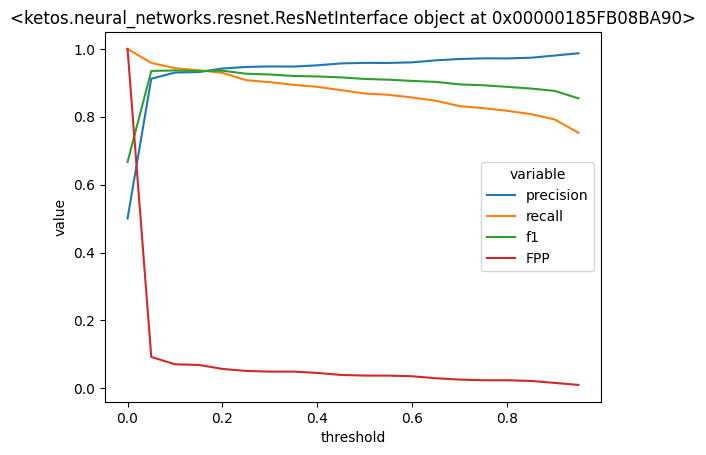

In [12]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\metrics'
temp_folder = main_folder + '\\' + 'temp'

for idx, model in enumerate(model_names):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/all')
    
    classification_csv = "classifications" + str(idx) + ".csv"
    metric_csv = "metrics"  + str(idx) + ".csv"
    stats_csv = "stats"  + str(idx) + ".csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folders[idx])
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

Confusion Matrix


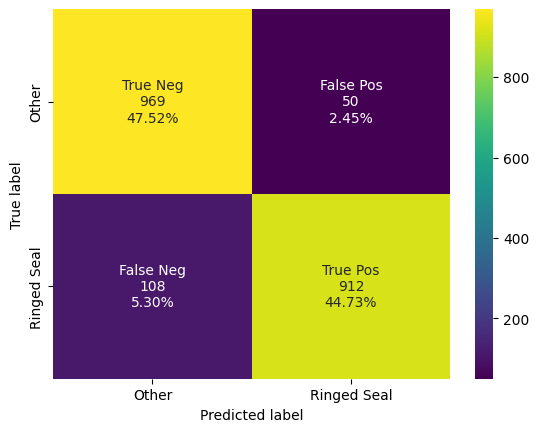

In [18]:
threshold = 0.35

#classifications_file = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\metrics\classifications-model-3.csv'
classifications_file = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\metrics\classifications\classifications3.csv'

classifications = pd.read_csv(classifications_file)

classifications_by_threshold = classifications[classifications['threshold']==threshold]

predictions = classifications_by_threshold['predicted']

labels = classifications_by_threshold['label']

cm = confusion_matrix_sklearn(labels, predictions)

labels = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
categories = ['Other', 'Ringed Seal']

confusion_matrix_plot(cm, output_dir, group_names=labels, categories=categories, cmap='viridis')

## Fine Tuning

In [2]:
ulu_neg_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\negatives-manual.xlsx')
ulu_neg_2023 = ulu_neg_2023.ffill()

num_tr = int(len(ulu_neg_2023)*0.70)
num_val = int(len(ulu_neg_2023)*0.20)
num_te = len(ulu_neg_2023) - num_tr - num_val

ulu_neg_tr = ulu_neg_2023[0:num_tr]
ulu_neg_val = ulu_neg_2023[num_tr:num_tr+num_val]
ulu_neg_te = ulu_neg_2023[num_tr+num_val:len(ulu_neg_2023)]

ulu_neg_tr = sl.standardize(table=ulu_neg_tr)
ulu_neg_val = sl.standardize(table=ulu_neg_val)
ulu_neg_te = sl.standardize(table=ulu_neg_te)

ulu_pos_2023 = pd.read_excel(r'D:\ringed_seal_selection_tables\ulu2023\positives.xlsx')
ulu_pos_2023 = ulu_pos_2023.ffill()

num_tr = int(len(ulu_pos_2023)*0.70)
num_val = int(len(ulu_pos_2023)*0.20)
num_te = len(ulu_pos_2023) - num_tr - num_val

ulu_pos_tr = ulu_pos_2023[0:num_tr]
ulu_pos_val = ulu_pos_2023[num_tr:num_tr+num_val]
ulu_pos_te = ulu_pos_2023[num_tr+num_val:len(ulu_pos_2023)]

ulu_pos_tr = sl.standardize(table=ulu_pos_tr, start_labels_at_1=True)
ulu_pos_val = sl.standardize(table=ulu_pos_val, start_labels_at_1=True)
ulu_pos_te = sl.standardize(table=ulu_pos_te, start_labels_at_1=True)

train = pd.concat([ulu_pos_tr, ulu_neg_tr])
test = pd.concat([ulu_pos_te, ulu_neg_te])
val = pd.concat([ulu_pos_val, ulu_neg_val])

In [5]:
db_name = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning\ulu_2023_split-db.h5'
data_folder = r'D:\ringed-seal-data'
spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

In [7]:
spec_cfg = load_audio_representation(spectro_file, name="spectrogram")

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'train', selections=train, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'val', selections=val, data_dir=data_folder,
                    audio_repres=spec_cfg)

dbi.create_database(output_file=db_name,  # empty brackets
                    dataset_name=r'test', selections=test, data_dir=data_folder,
                    audio_repres=spec_cfg)

100%|████████████████████████████████████████████████████████████████████████████████| 714/714 [00:12<00:00, 55.33it/s]


714 items saved to E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning\ulu_2023_split-db.h5


100%|████████████████████████████████████████████████████████████████████████████████| 204/204 [00:03<00:00, 54.99it/s]


204 items saved to E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning\ulu_2023_split-db.h5


100%|████████████████████████████████████████████████████████████████████████████████| 104/104 [00:02<00:00, 51.57it/s]

104 items saved to E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning\ulu_2023_split-db.h5


In [15]:
main_folder = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning'
model_folder = r'E:\baseline-with-normalization-reduce-tonal'

pretrained_model = [model_folder + "\\" + "rs-model-0.kt", model_folder + "\\" + "rs-model-1.kt", model_folder + "\\" + "rs-model-2.kt", 
                    model_folder + "\\" + "rs-model-3.kt", model_folder + "\\" + "rs-model-4.kt", model_folder + "\\" + "rs-model-5.kt",
                    model_folder + "\\" + "rs-model-6.kt", model_folder + "\\" + "rs-model-7.kt", model_folder + "\\" + "rs-model-8.kt",
                    model_folder + "\\" + "rs-model-9.kt"]

new_model = [main_folder + "\\" + "rs-model-0.kt", main_folder + "\\" + "rs-model-1.kt", main_folder + "\\" + "rs-model-2.kt", 
            main_folder + "\\" + "rs-model-3.kt", main_folder + "\\" + "rs-model-4.kt", main_folder + "\\" + "rs-model-5.kt",
            main_folder + "\\" + "rs-model-6.kt", main_folder + "\\" + "rs-model-7.kt", main_folder + "\\" + "rs-model-8.kt",
            main_folder + "\\" + "rs-model-9.kt"]

spectro_file = r'E:\baseline-with-normalization-reduce-tonal\spec_config_100-1200Hz-0.032-hamm-normalized-reduce-tonal.json'

np_seeds = [1736, 680, 1996, 1522, 867, 543, 249, 707, 584, 1236, 161]
tf_seeds = [1660, 977, 1396, 1456, 1539, 673, 1743, 1492, 1776, 1273, 394]

In [17]:
for idx, model in enumerate(pretrained_model):

    # Set the random seed for numpy and tensorflow
    np.random.seed(np_seeds[idx])
    tf.random.set_seed(tf_seeds[idx])
    
    # Set the batch size and number of epochs for training
    batch_size = 16
    n_epochs = 80
    
    # Set the log folder and checkpoint folder
    log_folder = main_folder + '\\' + 'logs' + str(idx)
    checkpoint_folder = main_folder + '\\' + 'checkpoints' + str(idx)
    
    # Open the database file in read mode
    db = dbi.open_file(db_name, 'r')
    
    # Open the training and validation tables respectively
    train_data = dbi.open_table(db, "/train/data")
    val_data = dbi.open_table(db, "/val/data")
    
    # Create batches of training data of size batch size, using the specified data table
    # This returns indices of the data in each batch along with their labels
    train_generator = BatchGenerator(batch_size=batch_size, data_table=train_data,
                                        output_transform_func=ResNetInterface.transform_batch,
                                        shuffle=True, refresh_on_epoch_end=True)
    
    # Create batches of validation data of size batch size, using the specified data table 
    # This returns indices of the data in each batch along with their labels 
    val_generator = BatchGenerator(batch_size=batch_size, data_table=val_data,
                                       output_transform_func=ResNetInterface.transform_batch,
                                       shuffle=False, refresh_on_epoch_end=False)
    
    # Load the pretrained model, replacing the top (aka. classification layers). This method inherently freezes the base.
    resnet = ResNetInterface.load(model, replace_top=True)
    
    # Set the training and validation generators to the batch generators created above
    resnet.train_generator = train_generator
    resnet.val_generator = val_generator
    
    # Set the model log and checkpoint directory
    resnet.log_dir = log_folder
    resnet.checkpoint_dir = checkpoint_folder
    
    # digging into their scripts for fine tuning
    # resnet.py, "clone with new top"
    
    # Train the model, looping through all of the training and validation data
    # See code map for more information
    resnet.train_loop(n_epochs=n_epochs, verbose=False, log_csv=True, csv_name='log.csv', validate=True)
    
    # Close the database
    db.close()
    
    # Save the model file, and keep track of the spectrogram parameters used to generate that model
    resnet.save(new_model[idx], audio_repr_file=spectro_file)
    
    print('Done')

Done
Done
Done
Done
Done
Done
Done
Done
Done
Done


In [3]:
folder = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning\logs'

files = glob.glob(folder + '\*.csv')

accuracy_tr = pd.DataFrame(columns=['epoch'])
precision_tr = pd.DataFrame(columns=['epoch'])
recall_tr = pd.DataFrame(columns=['epoch'])
loss_tr = pd.DataFrame(columns=['epoch'])

accuracy_val = pd.DataFrame(columns=['epoch'])
precision_val = pd.DataFrame(columns=['epoch'])
recall_val = pd.DataFrame(columns=['epoch'])
loss_val = pd.DataFrame(columns=['epoch'])

for idx, file in enumerate(files):

    csv_file = pd.read_csv(file)
        
    train_df = csv_file[csv_file['dataset'] == 'train']
    val_df = csv_file[csv_file['dataset'] == 'val']
    
    if idx == 0:
        accuracy_tr['epoch'] = train_df['epoch']
        precision_tr['epoch'] = train_df['epoch']
        recall_tr['epoch'] = train_df['epoch']
        loss_tr['epoch'] = train_df['epoch']
        
        accuracy_val['epoch'] = val_df['epoch']
        precision_val['epoch'] = val_df['epoch']
        recall_val['epoch'] = val_df['epoch']
        loss_val['epoch'] = val_df['epoch']
    
    model_name = file.split("\\")[-1].split('.')[0]
    
    accuracy_tr[model_name] = train_df['CategoricalAccuracy'].tolist()
    precision_tr[model_name] = train_df['Precision'].tolist()
    recall_tr[model_name] = train_df['Recall'].tolist()
    loss_tr[model_name] = train_df['loss'].tolist()
    
    accuracy_val[model_name] = val_df['CategoricalAccuracy'].tolist()
    precision_val[model_name] = val_df['Precision'].tolist()
    recall_val[model_name] = val_df['Recall'].tolist()
    loss_val[model_name] = val_df['loss'].tolist()

accuracy_tr['mean'] = accuracy_tr.loc[:, accuracy_tr.columns != 'epoch'].mean(axis=1)
accuracy_tr['std'] = accuracy_tr.loc[:, accuracy_tr.columns != 'epoch'].std(axis=1)

precision_tr['mean'] = precision_tr.loc[:, precision_tr.columns != 'epoch'].mean(axis=1)
precision_tr['std'] = precision_tr.loc[:, precision_tr.columns != 'epoch'].std(axis=1)

recall_tr['mean'] = recall_tr.loc[:, recall_tr.columns != 'epoch'].mean(axis=1)
recall_tr['std'] = recall_tr.loc[:, recall_tr.columns != 'epoch'].std(axis=1)

loss_tr['mean'] = loss_tr.loc[:, loss_tr.columns != 'epoch'].mean(axis=1)
loss_tr['std'] = loss_tr.loc[:, loss_tr.columns != 'epoch'].std(axis=1)

accuracy_val['mean'] = accuracy_val.loc[:, accuracy_val.columns != 'epoch'].mean(axis=1)
accuracy_val['std'] = accuracy_val.loc[:, accuracy_val.columns != 'epoch'].std(axis=1)

precision_val['mean'] = precision_val.loc[:, precision_val.columns != 'epoch'].mean(axis=1)
precision_val['std'] = precision_val.loc[:, precision_val.columns != 'epoch'].std(axis=1)

recall_val['mean'] = recall_val.loc[:, recall_val.columns != 'epoch'].mean(axis=1)
recall_val['std'] = recall_val.loc[:, recall_val.columns != 'epoch'].std(axis=1)

loss_val['mean'] = loss_val.loc[:, loss_val.columns != 'epoch'].mean(axis=1)
loss_val['std'] = loss_val.loc[:, loss_val.columns != 'epoch'].std(axis=1)

plt.plot(accuracy_tr['epoch'], accuracy_tr['mean'], '#377eb8', label='Train')
plt.fill_between(accuracy_tr['epoch'], accuracy_tr['mean'] - accuracy_tr['std'],
                 accuracy_tr['mean'] + accuracy_tr['std'], color='#377eb8', alpha=0.2)


plt.plot(accuracy_val['epoch'], accuracy_val['mean'], '#ff7f00', label='Val')
plt.fill_between(accuracy_val['epoch'], accuracy_val['mean'] - accuracy_val['std'],
                 accuracy_val['mean'] + accuracy_val['std'], color='#ff7f00', alpha=0.2)

plt.title("Average Accuracy Curve with Shaded Standard Deviation")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.savefig(folder + "\\" + 'average-accuracy.png')
plt.close()

plt.plot(loss_tr['epoch'], loss_tr['mean'], '#377eb8', label='Train')
plt.fill_between(loss_tr['epoch'], loss_tr['mean'] - loss_tr['std'],
                 loss_tr['mean'] + loss_tr['std'], color='#377eb8', alpha=0.2)


plt.plot(loss_val['epoch'], loss_val['mean'], '#ff7f00', label='Val')
plt.fill_between(loss_val['epoch'], loss_val['mean'] - loss_val['std'],
                 loss_val['mean'] + loss_val['std'], color='#ff7f00', alpha=0.2)

plt.title("Average Loss Curve with Shaded Standard Deviation")
plt.xlabel("Epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig(folder + "\\" + 'average-loss.png')
plt.close()

plt.plot(recall_tr['epoch'], recall_tr['mean'], '#377eb8', label='Train')
plt.fill_between(recall_tr['epoch'], recall_tr['mean'] - recall_tr['std'],
                 recall_tr['mean'] + recall_tr['std'], color='#377eb8', alpha=0.2)


plt.plot(recall_val['epoch'], recall_val['mean'], '#ff7f00', label='Val')
plt.fill_between(recall_val['epoch'], recall_val['mean'] - recall_val['std'],
                 recall_val['mean'] + recall_val['std'], color='#ff7f00', alpha=0.2)

plt.title("Average Recall Curve with Shaded Standard Deviation")
plt.xlabel("Epoch")
plt.ylabel("recall")
plt.legend()
plt.savefig(folder + "\\" + 'average-recall.png')
plt.close()

plt.plot(precision_tr['epoch'], precision_tr['mean'], '#377eb8', label='Train')
plt.fill_between(precision_tr['epoch'], precision_tr['mean'] - precision_tr['std'],
                 precision_tr['mean'] + precision_tr['std'], color='#377eb8', alpha=0.2)


plt.plot(precision_val['epoch'], precision_val['mean'], '#ff7f00', label='Val')
plt.fill_between(precision_val['epoch'], precision_val['mean'] - precision_val['std'],
                 precision_val['mean'] + precision_val['std'], color='#ff7f00', alpha=0.2)

plt.title("Average Precision Curve with Shaded Standard Deviation")
plt.xlabel("Epoch")
plt.ylabel("precision")
plt.legend()
plt.savefig(folder + "\\" + 'average-precision.png')
plt.close()

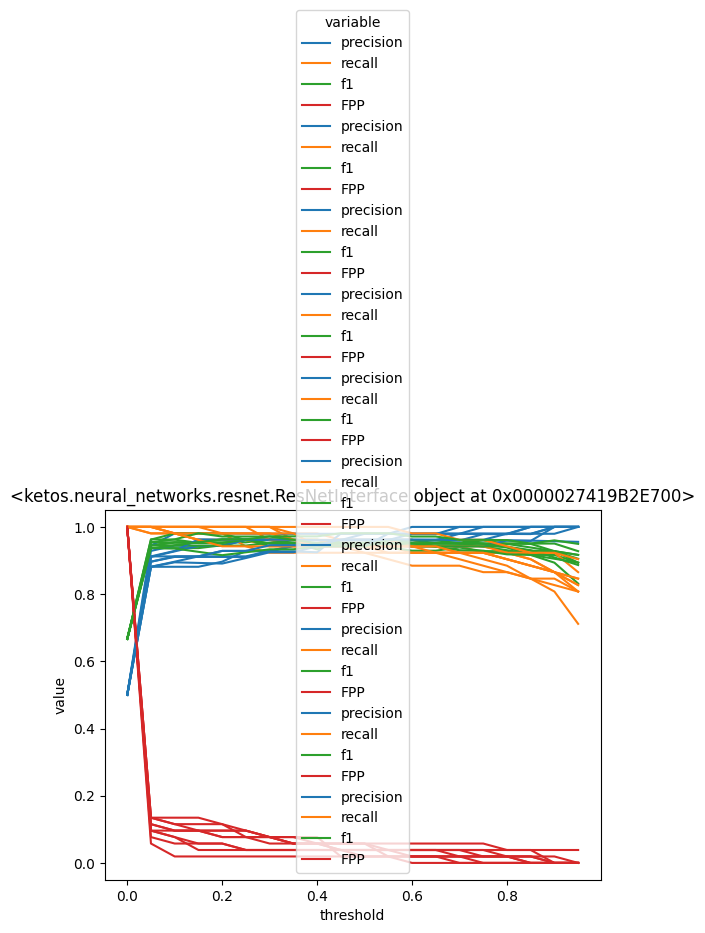

In [16]:
thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
step_size = 1.0
batch_size = 16
buffer = 0.5

# Get pathway to metrics folder
output_dir = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\metrics\test-subset\metrics'
temp_folder = main_folder + '\\' + 'temp'
db_name = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\fine-tuning\ulu_2023_split-db.h5'

for idx, model in enumerate(pretrained_model):
    
    # Open the database in read only file
    db = dbi.open_file(db_name, 'r')
    
    # Open the table in the database at the root level
    table = dbi.open_table(db, '/test')
    
    classification_csv = "classifications" + str(idx) + ".csv"
    metric_csv = "metrics"  + str(idx) + ".csv"
    stats_csv = "stats"  + str(idx) + ".csv"
    
    # Load the trained model
    model = ResNetInterface.load(model, load_audio_repr=False, new_model_folder=temp_folder)
    
    # Initialize Joint Batch Generator
    gens = []
    
    # Calculate the batch_size fixing the original batch size so there are no remainders
    batch_size = int(batch_size / sum(1 for _ in db.walk_nodes(table, "Table")))
    
    # for the testing dataset table in the database (or whatever table is passed in)
    for group in db.walk_nodes(table, "Table"):
        # Create a batch generator for this table
        generator = BatchGenerator(batch_size=batch_size, data_table=group,
                                   output_transform_func=ResNetInterface.transform_batch, shuffle=False,
                                   refresh_on_epoch_end=False, x_field='data', return_batch_ids=True)
    
        # Append the generator to the gens array
        gens.append(generator)
    
    # Create a joint batch generator if multiple tables are passed through
    gen = JointBatchGen(gens, n_batches='min', shuffle_batch=False, reset_generators=False, return_batch_ids=True)
    
    # Initialize the scores and labels
    scores = []
    labels = []
    
    # For each batch in the joint batch generator
    for batch_id in range(gen.n_batches):
        # Get the ids, spectrograms, and labels for the data in the batch
        hdf5_ids, batch_X, batch_Y = next(gen)
    
        # Get the labels for the batch data, using the "argmax" func which returns the col header, so 0 is a noise segment, 1 is a rs segment
        batch_labels = np.argmax(batch_Y, axis=1)
    
        # Returns the scores for the batch for the "positive" class - this is used in the compute detections function later on
        batch_scores = model.model.predict_on_batch(batch_X)[:, 1]
    
        # Add these scores for this batch to the overall list
        scores.extend(batch_scores)
        labels.extend(batch_labels)
    
    # Create a numpy array for the labels and scores for all batches
    labels = np.array(labels)
    scores = np.array(scores)
    
    df_groups = pd.DataFrame()
    df_stats = pd.DataFrame(columns = ['threshold', 'precision', 'recall', 'f1', 'FPP'])
    
    for threshold in thresholds:
    
        df_group = pd.DataFrame()
    
        # Compute the predictions, TP, TN, FP, and FN
        # Predicted is an array are greater than a certain threshold, 1 for the score was, 0 for it was not
        predicted, TP, TN, FP, FN = compute_detections(labels, scores, threshold)
    
        # Create the "classifications" csv file
        for group in db.walk_nodes(table, "Table"):
            df = pd.DataFrame({'id': group[:]['id'], 'filename': group[:]['filename']})
            df_group = pd.concat([df_group, df], ignore_index=True)
        df_group['threshold'] = threshold
        df_group['label'] = labels[:]
        df_group['predicted'] = predicted[:]
        df_group['score'] = scores[:]
    
        # Calculate performance metrics
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        f1 = 2 * precision * recall / (precision + recall)
        FPP = FP / (TN + FP)
    
        stats = [threshold, precision, recall, f1, FPP]
    
        df_groups = pd.concat([df_groups, df_group])
        df_stats.loc[len(df_stats)] = stats
    
    df_groups.to_csv(os.path.join(os.getcwd(), output_dir, classification_csv), mode='w', index=False)
    df_stats.to_csv(os.path.join(os.getcwd(), output_dir, stats_csv), mode='w', index=False)
    
    sns.lineplot(x='threshold', y='value', hue='variable', data=pd.melt(df_stats, ['threshold']))
    plt.title(model)
    
    db.close()

precision is 0.9505472214834828std of 0.014381622173742769
recall is 0.953846153846154std of 0.021414478318576968
test


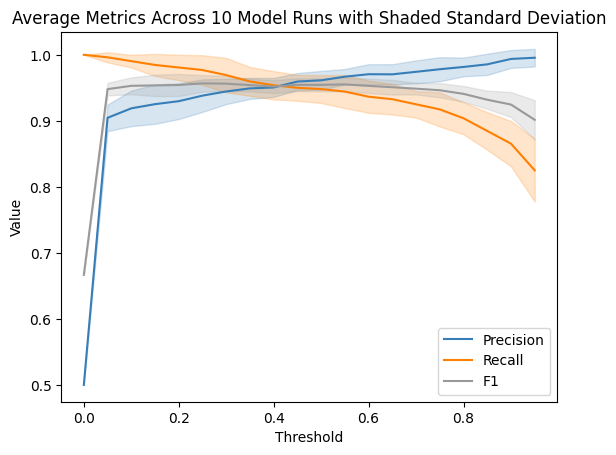

In [19]:
import pandas as pd
import glob
import matplotlib.pyplot as plt

folder = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\metrics\test-subset\metrics\stats'

files = glob.glob(folder + '\*.csv')

precision = pd.DataFrame(columns=['threshold'])
recall = pd.DataFrame(columns=['threshold'])
f1 = pd.DataFrame(columns=['threshold'])

for idx, file in enumerate(files):

    csv_f = pd.read_csv(file)

    if idx == 0:
        precision['threshold'] = csv_f['threshold']
        recall['threshold'] = csv_f['threshold']
        f1['threshold'] = csv_f['threshold']

    model_name = file.split("\\")[-1].split('.')[0]
    precision[model_name] = csv_f['precision'].tolist()
    recall[model_name] = csv_f['recall'].tolist()
    f1[model_name] = csv_f['f1'].tolist()

precision['mean'] = precision.loc[:, precision.columns != 'threshold'].mean(axis=1)
precision['std'] = precision.loc[:, precision.columns != 'threshold'].std(axis=1)
precision['mean+std'] = precision['mean'] + precision['std']
precision['mean-std'] = precision['mean'] - precision['std']

recall['mean'] = recall.loc[:, recall.columns != 'threshold'].mean(axis=1)
recall['std'] = recall.loc[:, recall.columns != 'threshold'].std(axis=1)
recall['mean+std'] = recall['mean'] + recall['std']
recall['mean-std'] = recall['mean'] - recall['std']

f1['mean'] = f1.loc[:, f1.columns != 'threshold'].mean(axis=1)
f1['std'] = f1.loc[:, f1.columns != 'threshold'].std(axis=1)
f1['mean+std'] = f1['mean'] + f1['std']
f1['mean-std'] = f1['mean'] - f1['std']

#dfm = precision.melt('threshold', var_name='cols', value_name='vals')
#g = sns.catplot(x="threshold", y="vals", hue='cols', data=dfm, kind='point')

plt.plot(precision['threshold'], precision['mean'], '#377eb8', label='Precision')
plt.fill_between(precision['threshold'], precision['mean-std'], precision['mean+std'], color='#377eb8', alpha=0.2)

plt.plot(recall['threshold'], recall['mean'], '#ff7f00', label='Recall')
plt.fill_between(recall['threshold'], recall['mean-std'], recall['mean+std'], color='#ff7f00', alpha=0.2)

plt.plot(f1['threshold'], f1['mean'], '#999999', label='F1')
plt.fill_between(f1['threshold'], f1['mean-std'], f1['mean+std'], color='#999999', alpha=0.2)

plt.legend()
plt.title('Average Metrics Across 10 Model Runs with Shaded Standard Deviation')
plt.xlabel('Threshold')
plt.ylabel('Value')
plt.savefig(folder + '\\' + 'average_metrics.png')

print('precision is ' + str(float(precision[precision['threshold']==0.4]['mean'])) + 'std of ' + str(float(precision[precision['threshold']==0.4]['std'])))
print('recall is ' + str(float(recall[recall['threshold']==0.4]['mean'])) + 'std of ' + str(float(recall[recall['threshold']==0.4]['std'])))

print('test')

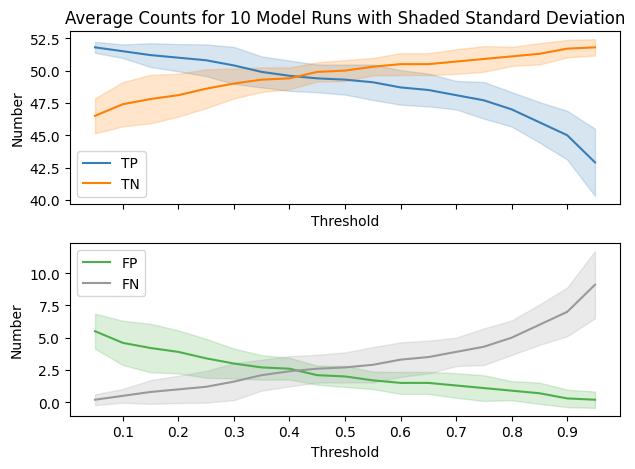

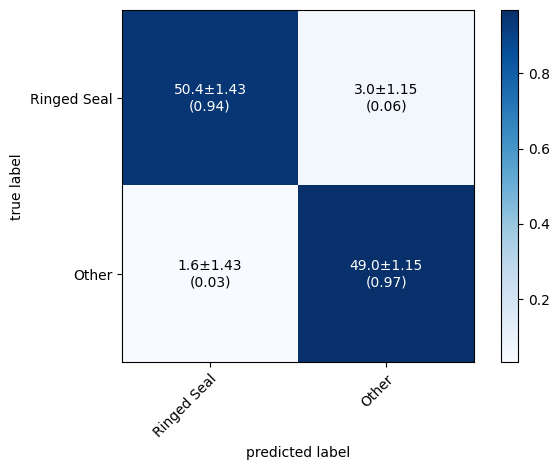

In [17]:
import pandas as pd
import numpy as np
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)


def compute_detections(labels, scores, threshold):
    # Compute the positive scores above threshold, 1 if it is above threshold, 0 if it is not
    predictions = np.where(scores >= threshold, 1, 0)

    # TP: Does the annotated label match the prediction above threshold? Bc "scores" is defined as the positive threshold, this represents TP
    TP = tf.math.count_nonzero(predictions * labels).numpy()

    # TN: Negative score is "predictions - 1" bc predictions was for the positive result, labels-1 so that the negatives are multiplied by 1
    TN = tf.math.count_nonzero((predictions - 1) * (labels - 1)).numpy()

    # And so on
    FP = tf.math.count_nonzero(predictions * (labels - 1)).numpy()
    FN = tf.math.count_nonzero((predictions - 1) * labels).numpy()

    return predictions, TP, TN, FP, FN


folder = r'E:\baseline-with-normalization-reduce-tonal\deploy\ulu2023\metrics\test-subset\metrics\classifications'

files = glob.glob(folder + '\*.csv')

thresholds = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9,
              0.95, 1]

all = []

for idx, file in enumerate(files):

    class_file = pd.read_csv(file)

    for threshold in thresholds:
        temp = class_file[class_file['threshold'] == threshold]

        predicted, TP, TN, FP, FN = compute_detections(temp['label'], temp['score'], threshold)

        model_name = file.split("\\")[-1].split('.')[0]
        temp_array = [model_name, threshold, TP, TN, FP, FN]

        all.append(temp_array)

        # method deprecated bc slow
        # filled_df = filled_df.append(temp_array, ignore_index=True)

df = pd.DataFrame(all, columns=["model", "threshold", "TP", "TN", "FP", "FN"])

all_calcs = []

for threshold in thresholds:
    df_temp = df[df['threshold'] == threshold]

    TP_avg = df_temp['TP'].mean()
    TP_std = df_temp['TP'].std()

    TN_avg = df_temp['TN'].mean()
    TN_std = df_temp['TN'].std()

    FP_avg = df_temp['FP'].mean()
    FP_std = df_temp['FP'].std()

    FN_avg = df_temp['FN'].mean()
    FN_std = df_temp['FN'].std()

    all_calcs.append([threshold, TP_avg, TP_std, TN_avg, TN_std, FP_avg, FP_std, FN_avg, FN_std])

df_calcs = pd.DataFrame(all_calcs, columns=["threshold", "TP_avg", "TP_std", "TN_avg", "TN_std", "FP_avg",
                                            "FP_std", "FN_avg", "FN_std"])

df_calcs_edited = df_calcs[df_calcs['threshold'] != 0]
df_calcs_edited = df_calcs_edited[df_calcs_edited['threshold'] != 1]

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.set_title("Average Counts for 10 Model Runs with Shaded Standard Deviation")

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TP_avg'], '#377eb8', label='TP')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TP_avg"] - df_calcs_edited["TP_std"],
                 df_calcs_edited["TP_avg"] + df_calcs_edited["TP_std"], color='#377eb8', alpha=0.2)

ax1.plot(df_calcs_edited['threshold'], df_calcs_edited['TN_avg'], '#ff7f00', label='TN')
ax1.fill_between(df_calcs_edited['threshold'], df_calcs_edited["TN_avg"] - df_calcs_edited["TN_std"],
                 df_calcs_edited["TN_avg"] + df_calcs_edited["TN_std"], color='#ff7f00', alpha=0.2)

ax1.set_xlabel("Threshold")
ax1.set_ylabel("Number")
ax1.legend()

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FP_avg'], '#4daf4a', label='FP')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FP_avg"] - df_calcs_edited["FP_std"],
                 df_calcs_edited["FP_avg"] + df_calcs_edited["FP_std"], color='#4daf4a', alpha=0.2)

ax2.plot(df_calcs_edited['threshold'], df_calcs_edited['FN_avg'], '#999999', label='FN')
ax2.fill_between(df_calcs_edited['threshold'], df_calcs_edited["FN_avg"] - df_calcs_edited["FN_std"],
                 df_calcs_edited["FN_avg"] + df_calcs_edited["FN_std"], color='#999999', alpha=0.2)
ax2.set_xlabel("Threshold")
ax2.set_ylabel("Number")
ax2.legend()

plt.xticks([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
plt.tight_layout()
# plt.show()
plt.savefig(folder + '\\' + 'average_counts.png')


## Plot Confusion Matrix

df_confs = df_calcs_edited[df_calcs_edited['threshold']==0.3]

from mlxtend.plotting import plot_confusion_matrix

# Your Confusion Matrix
cm = np.array([[round(float(df_confs['TP_avg']), 2), round(float(df_confs['FP_avg']), 2)],
               [round(float(df_confs['FN_avg']), 2), round(float(df_confs['TN_avg']), 2)]])

error = np.array([[round(float(df_confs['TP_std']), 2), round(float(df_confs['FP_std']), 2)],
               [round(float(df_confs['FN_std']), 2), round(float(df_confs['TN_std']), 2)]])

# Classes
classes = ['Ringed Seal', 'Other']

figure2, ax = plot_confusion_matrix(conf_mat = cm,
                                   class_names = classes,
                                   show_absolute = True,
                                   show_normed = True,
                                   colorbar = True,
                                   error = error)


plt.tight_layout()
plt.savefig(folder + '\\' + 'confusion_matrix_avg.png')